# User's Guide, Chapter 13: More Music21Object Attributes and Properties

At this point you know how to find a `Music21Object`, how to name them and group them (with `.id` and `.groups`) and how to position them in Streams (with `.offset`, `.priority`, `.classSortOrder` and the `.activeSite`). This section gets first into some more advanced things that Music21Objects have, then some more fun things.

### Sites and the storing of elements

All `Music21Objects` (i.e., elements) have a `.sites` property which is a :class:`~music21.sites.Sites` object which holds information about all the places the `Music21Object` is stored in. At its simplest, it's something that can be iterated over:

In [1]:
from music21 import *

n = note.Note()
s1 = stream.Stream(id='s1')
s2 = stream.Stream(id='s2')
s1.insert(10, n)
s2.insert(20, n)

for s in n.sites:
    print(s, s.elementOffset(n))

<music21.stream.Stream s1> 10.0
<music21.stream.Stream s2> 20.0


Note that the order of the Streams in `.sites` is guaranteed to be the order in which the note was inserted into the site.

There's a lot more that `.sites` can do, but primarily for developers.  We will get back to sites later.

### Derivations

We will talk about derivations more in a future chapter, butwe alluded to them in the Example in chapter 10, so let's say a few words about this advanced feature. A :class:`~music21.derivation.Derivation` object is a pointer to an object that this object is derived from in some way.  They've gone their separate ways to an extent, but may want to talk to each other later.  A `Music21Object` starts out with no useful Derivation:

In [2]:
c = note.Note("C4")
c.derivation

<Derivation of <music21.note.Note C> from None via "None">

But we can create new notes from it and they're not totally connected, but show their connection through `.derivation`:

In [3]:
f = c.transpose('P4')
f

<music21.note.Note F>

In [4]:
f.derivation

<Derivation of <music21.note.Note F> from <music21.note.Note C> via "transpose">

Now `c` has a life of its own from `f`.  We can add a sharp to C and the transpose relationship of F to C does not affect it:

In [5]:
c.pitch.accidental = pitch.Accidental('sharp')
(c, f)

(<music21.note.Note C#>, <music21.note.Note F>)

But if `f` wants to do something to `c`, it can by changing itself and every element of its `.derivation.chain()`:

In [6]:
f.notehead = 'diamond'
for n in f.derivation.chain():
    n.notehead = 'diamond'

(f.notehead, c.notehead)

('diamond', 'diamond')

While `f` can search upwards in its `.derivation.chain()` and find `c`, `c` cannot find `f` in its derivation; it is a connection that is designed to be one-way only.

Setting derivations can be done manually, but it's an advanced enough topic that we will get to it later.

### Context attributes

Several attributes of `Music21Objects` only work after the object has been placed inside a Stream that has certain features of their own.

An easy one to understand is `.measureNumber` which finds the `.number` value of the measure that an object is placed in:

In [7]:
n = note.Note('C')
m = stream.Measure()
m.number = 7
m.append(n)
n.measureNumber

7

This works even if a note is inside a voice inside a measure:

In [8]:
v = stream.Voice()
n2 = note.Note('D')
v.append(n2)
m.insert(0, v)
n2.measureNumber

7

Without a context, you'll get None

In [9]:
n3 = note.Note()
n3.measureNumber is None

True

The second context attribute is, appropriately, called `.seconds`.  It requires a tempo.MetronomeMark() to be placed into the Stream before the object and will calculate how many seconds the object (note, etc.) lasts at that tempo:

In [10]:
m.insert(0, tempo.MetronomeMark('Allegro', 120))
print (n.quarterLength, n.seconds)

1.0 0.5


Unlike `.measureNumber` and the rest of the attributes we will see below, you can change `.seconds` to reflect exact timing you might have from audio or MIDI data.

In [11]:
n.seconds = 0.6
n.seconds

0.6

An object with no tempo information in its surrounding context returns an error for `.seconds`

In [12]:
n3 = note.Note('E')
n3.seconds

Music21ObjectException: this object does not have a TempoIndication in Sites

So use `try...except...` to catch this:

In [13]:
for el in (n, n2, n3):
    seconds = "No information"
    try:
        seconds = el.seconds
    except exceptions21.Music21Exception:
        pass
    print(el.step, seconds)

C 0.6
D 0.5
E No information


The last three context attributes, `.beat`, `.beatStr` (beat string), and `.beatStrength`, all require :class:`~music21.meter.TimeSignature` contexts. Since they're the topic of :ref:`our next chapter<usersGuide_14_timeSignatures>` we'll put them off until then.

Most `Music21Objects` such as `Notes` have many additional attributes, but these are all the ones that are common to every object that can go in a `Stream` (after all, what would `.step` mean for a :class:`~music21.tempo.MetronomeMark`?)

## Methods on `Music21Objects`

Attributes and properties are aspects of an object that are lightweight and have no configuration options, so they are accessed without `()`. Methods tend to do more work and have more options, so they will always be called with `()` signs.

Unlike attributes, where we have documented all of them, only a subset of the methods on `Music21Objects` are listed below.  All of them can be found in the documentation to :class:`~music21.base.Music21Object`, but many of them have obscure uses and might be moved later to not clutter up what is really important!  And those are...

### .getOffsetBySite and .setOffsetBySite

These methods work as the `.offset` attribute but can work on any site where the object is a part of.

In [14]:
n = note.Note()
s1 = stream.Stream(id="s1")
s1.insert(10, n)
s2 = stream.Stream(id="s2")
s2.insert(20, n)
n.getOffsetBySite(s1)

10.0

In [15]:
n.setOffsetBySite(s1, 15.0)
n.getOffsetBySite(s1)

15.0

There is one extra possible attribute on `.getOffsetBySite`, "stringReturns=True" which will say whether or not an element has a shifting offset.  Right barlines have one:

In [16]:
s3 = stream.Measure()
n3 = note.Note(type='whole')
s3.append(n3)
rb = bar.Barline()
s3.rightBarline = rb
rb.getOffsetBySite(s3)

4.0

In [17]:
rb.getOffsetBySite(s3, stringReturns=True)

'highestTime'

And in fact if we change the duration of `n3` the position of the barline will shift along with it:

In [18]:
n3.duration.type = 'half'
rb.getOffsetBySite(s3)

2.0

### getContextByClass()

This is an extremely powerful tool -- you might not use it often, but be assured that `music21` is using it on your behalf all the time when sophisticated analysis is involved.  It finds the active element matching a certain class preceeding the element.  Let me demonstrate:

In [19]:
bach = corpus.parse('bwv66.6')
lastNote = bach.recurse().getElementsByClass('Note')[-1]
lastNote

<music21.note.Note F#>

What part is it in?

In [20]:
lastNote.getContextByClass('Part')

<music21.stream.Part Bass>

What is the KeySignature at that moment?

In [21]:
lastNote.getContextByClass('KeySignature')

<music21.key.KeySignature of 3 sharps, mode minor>

What is the TimeSignature at that moment?

In [22]:
lastNote.getContextByClass('TimeSignature')

<music21.meter.TimeSignature 4/4>

Why is this such a sophisticated method? It knows about the differences in different types of Streams.  If the key signature changes in a different part then it doesn't affect the notes of the current part, but if it changes in a previous measure in the same part, then that matters.  Furthermore, the caching mechanism via something called `Timespans` is amazingly fast, so that running through an entire score getting the context for each object doesn't take long at all:

In [23]:
gloria = corpus.parse('luca/gloria')
soprano = gloria.parts[0]

lastTimeSignature = None
for n in soprano.recurse().getElementsByClass('Note'):
    thisTimeSignature = n.getContextByClass('TimeSignature')
    if thisTimeSignature is not lastTimeSignature:
        lastTimeSignature = thisTimeSignature
        print(thisTimeSignature, n.measureNumber)

<music21.meter.TimeSignature 6/8> 1
<music21.meter.TimeSignature 2/4> 28
<music21.meter.TimeSignature 6/8> 80
<music21.meter.TimeSignature 3/4> 110


As you might expect, the `.measureNumber` routine uses `.getContextByClass('Measure')` internally. What is also interesting is that `.getContextByClass` is smart enough to search out derivation chains to find what it is looking for.  For instance, this flat stream has only notes, no time signatures.  But it can still find each note's time signature ane measure number context.

In [24]:
lastTimeSignature = None
for n in soprano.flat.notes:
    thisTimeSignature = n.getContextByClass('TimeSignature')
    if thisTimeSignature is not lastTimeSignature:
        lastTimeSignature = thisTimeSignature
        print(thisTimeSignature, n.measureNumber)

<music21.meter.TimeSignature 6/8> 1
<music21.meter.TimeSignature 2/4> 28
<music21.meter.TimeSignature 6/8> 80
<music21.meter.TimeSignature 3/4> 110


Internally `.getContextByClass` uses another `Music21Object` method called `.contextSites()` which is a generator that tells the system where to search next:

In [25]:
for cs in lastNote.contextSites():
    print(cs)

(<music21.stream.Measure 9 offset=33.0>, 2.0, 'elementsFirst')
(<music21.stream.Part Bass>, 35.0, 'flatten')
(<music21.stream.Score 0x10b6116a0>, 35.0, 'elementsOnly')


This says that first the elements of Measure 9 should be searched, beginning at 2.0 and working backwards to the beginning of the measure, then if the matching context isn't found, the measure will be flattened (in case there are other voices in the measure) and anything from before offset 2.0 of that flattened stream will be searched.

If that fails, then the Bass part as a whole will be searched, with all elements flattened, beginning at offset 35 and working backwards.  That way if the context is in another measure it will be found.

Then if that fails, it will look at the score as a whole, beginning at offset 35 and working backwards, but only looking at things that are at the score level, not looking at elements within other parts. There may be scores where for instance, expressive markings appear at the Score level. This will find them.

Related to `.getContextByClass()` is `.getAllContextsByClass()` which is a generator that returns each preceeding context.

In [26]:
lastGloriaNote = soprano.flat.notes[-1]

for ts in lastGloriaNote.getAllContextsByClass('TimeSignature'):
    print(ts, ts.measureNumber)

<music21.meter.TimeSignature 3/4> 110
<music21.meter.TimeSignature 6/8> 80
<music21.meter.TimeSignature 2/4> 28
<music21.meter.TimeSignature 6/8> 1


Similar to `.getContextByClass()` are the `.next(class)` and `.previous(class)` methods which move to the next or previous element of the same class at the same (or a higher) hierarchical level.  They're designed to be really easy to use, but so far, I've failed at achieving that.  Hopefully in the next few versions I'll be able to demonstrate in practice how these commands were designed to work.  For now, I'd suggest avoiding them.

### Splitting methods

`Music21` has three methods on `Music21Object`s for splitting them.  Eventually the plan is to unite them into a single `.split()` method, but we're not there yet.

The three methods are:

* `.splitAtQuarterLength` -- splits an object into two objects at the given quarter length
* `.splitByQuarterLengths` -- splits an object into two or more objects according to a list of quarter lengths
* `.splitAtDurations` -- takes an object with a complex duration (such as 5.0 quarters) and splits it into notatable units.

These all work rather similarly.  Behind their seeming simplicity are a host of complex musical decisions that are being made.  Take this rather complex note (we're introducing `expressions` and `articulations` softly here):

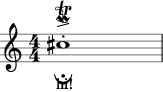

In [27]:
n = note.Note('C#5')
n.duration.type = 'whole'
n.articulations = [articulations.Staccato(), articulations.Accent()]
n.lyric = 'hi!'
n.expressions = [expressions.Mordent(), expressions.Trill(), expressions.Fermata()]
n.show()

Now let's split this note at the 3/4 mark:

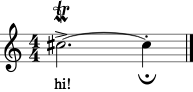

In [28]:
splitTuple = n.splitAtQuarterLength(3.0)
s = stream.Stream()
s.append(splitTuple)
s.show()

Notice the choices that `music21` made -- the two notes are tied, the lyrics are sung at the beginning, the accent and mordent appear at the beginning of the note while the staccato and fermata(!) appear on the second note, while trill mark gets put onto the first note only. This is part of the "batteries included" `music21` approach -- try to do something musically smart in most cases.  In fact, it's even a bit smarter -- the `splitTuple` knows that there's something called a TrillExtension spanner in it which should be put into the Stream:

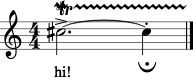

In [29]:
for thisSpanner in splitTuple.spannerList:
    s.insert(0, thisSpanner)
s.show()

### Showing and Writing

The two last methods are almost certainly the most important: `.show()` and `.write()`.  We've been using `.show()` throughout the User's Guide, so it's familiar.  It usually takes a single argument which is the format (default is `'musicxml'` except on IPython where it is `'musicxml.png'`.  `.write()` by contrast writes out the file to disk.  The first argument is again the format.  The second argument, optional, is the filename with path.  If omitted then a temporary file is written (and the filename is returned).

We'll see enough about `.show()` and `.write()` later, so that's enough for now on this long chapter.  Let's return to the `.beat` related function in :ref:`Chapter 14, Time Signatures <usersGuide_14_timeSignatures>`.